In [5]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)

print("=" * 60)
print("🔧 FEATURE ENGINEERING FOR DEMAND FORECASTING")
print("=" * 60)
print("✅ Libraries imported!")

🔧 FEATURE ENGINEERING FOR DEMAND FORECASTING
✅ Libraries imported!


In [6]:
# Cell 2: Load Data
df = pd.read_csv('../data/raw/grocery_sales.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"📊 Dataset Shape: {df.shape}")
print(f"📅 Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"\nColumns: {list(df.columns)}")

# Sort by date (CRITICAL for time series!)
df = df.sort_values(['item_id', 'store_id', 'date']).reset_index(drop=True)
print("\n✅ Data sorted by item, store, and date")

📊 Dataset Shape: (182500, 20)
📅 Date Range: 2023-01-01 00:00:00 to 2024-12-30 00:00:00

Columns: ['date', 'year', 'month', 'day', 'day_of_week', 'day_name', 'is_weekend', 'is_holiday', 'store_id', 'store_type', 'store_size', 'item_id', 'product_name', 'category', 'perishability_days', 'base_price', 'price', 'on_promotion', 'sales', 'revenue']

✅ Data sorted by item, store, and date


In [7]:
# Cell 3: Lag Features (Most Important for Forecasting!)
print("🔄 Creating Lag Features...")
print("=" * 60)

# Create lag features for each item-store combination
lag_periods = [1, 7, 14, 28]  # Yesterday, last week, 2 weeks ago, 4 weeks ago

for lag in lag_periods:
    df[f'sales_lag_{lag}'] = df.groupby(['item_id', 'store_id'])['sales'].shift(lag)
    print(f"✅ Created lag_{lag} feature")

print("\nLag features created:")
print([col for col in df.columns if 'lag' in col])

🔄 Creating Lag Features...
✅ Created lag_1 feature
✅ Created lag_7 feature
✅ Created lag_14 feature
✅ Created lag_28 feature

Lag features created:
['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28']


In [8]:
# Cell 4: Rolling Window Features (Moving Averages & Trends)
print("📊 Creating Rolling Window Features...")
print("=" * 60)

windows = [7, 14, 28]  # 1 week, 2 weeks, 4 weeks

for window in windows:
    # Rolling mean
    df[f'sales_rolling_mean_{window}'] = df.groupby(['item_id', 'store_id'])['sales'].transform(
        lambda x: x.shift(1).rolling(window, min_periods=1).mean()
    )
    
    # Rolling std (volatility)
    df[f'sales_rolling_std_{window}'] = df.groupby(['item_id', 'store_id'])['sales'].transform(
        lambda x: x.shift(1).rolling(window, min_periods=1).std()
    )
    
    # Rolling max
    df[f'sales_rolling_max_{window}'] = df.groupby(['item_id', 'store_id'])['sales'].transform(
        lambda x: x.shift(1).rolling(window, min_periods=1).max()
    )
    
    # Rolling min
    df[f'sales_rolling_min_{window}'] = df.groupby(['item_id', 'store_id'])['sales'].transform(
        lambda x: x.shift(1).rolling(window, min_periods=1).min()
    )
    
    print(f"✅ Created rolling features for window={window}")

print(f"\n✅ Total rolling features: {len([col for col in df.columns if 'rolling' in col])}")

📊 Creating Rolling Window Features...
✅ Created rolling features for window=7
✅ Created rolling features for window=14
✅ Created rolling features for window=28

✅ Total rolling features: 12


In [9]:
# Cell 5: Time-Based Features
print("📅 Creating Advanced Time Features...")
print("=" * 60)

# Week of year
df['week_of_year'] = df['date'].dt.isocalendar().week

# Quarter
df['quarter'] = df['date'].dt.quarter

# Is month start/end
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

# Days since start (trend)
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

# Day of month
df['day_of_month'] = df['date'].dt.day

# Cyclical encoding for month (sine/cosine)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Cyclical encoding for day of week
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

print("✅ Time-based features created:")
time_features = ['week_of_year', 'quarter', 'is_month_start', 'is_month_end', 
                 'days_since_start', 'day_of_month', 'month_sin', 'month_cos', 
                 'dow_sin', 'dow_cos']
for feat in time_features:
    print(f"   • {feat}")

📅 Creating Advanced Time Features...
✅ Time-based features created:
   • week_of_year
   • quarter
   • is_month_start
   • is_month_end
   • days_since_start
   • day_of_month
   • month_sin
   • month_cos
   • dow_sin
   • dow_cos


In [10]:
# Cell 6: Price Features
print("💰 Creating Price Features...")
print("=" * 60)

# Price change from base price
df['price_discount_pct'] = ((df['base_price'] - df['price']) / df['base_price']) * 100

# Price relative to category average
category_avg_price = df.groupby('category')['price'].transform('mean')
df['price_vs_category_avg'] = df['price'] / category_avg_price

print("✅ Price features created:")
print("   • price_discount_pct")
print("   • price_vs_category_avg")

💰 Creating Price Features...
✅ Price features created:
   • price_discount_pct
   • price_vs_category_avg


In [11]:
# Cell 7: Interaction Features
print("🔀 Creating Interaction Features...")
print("=" * 60)

# Weekend + Promotion interaction
df['weekend_promo'] = df['is_weekend'] * df['on_promotion']

# Holiday + Promotion interaction
df['holiday_promo'] = df['is_holiday'] * df['on_promotion']

# Category encoding (will be useful for models)
df['category_encoded'] = df['category'].astype('category').cat.codes

# Store type encoding
df['store_type_encoded'] = df['store_type'].astype('category').cat.codes

# Store size encoding
df['store_size_encoded'] = df['store_size'].astype('category').cat.codes

print("✅ Interaction features created")
print(f"\n📊 Total features now: {df.shape[1]}")

🔀 Creating Interaction Features...
✅ Interaction features created

📊 Total features now: 53


In [12]:
# Cell 8: Handle Missing Values
print("🔍 Checking Missing Values...")
print("=" * 60)

missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print("Missing values found (expected due to lag features):")
    print(missing)
    
    # Drop rows with missing lag features (first few days of each item-store)
    print(f"\nOriginal shape: {df.shape}")
    df = df.dropna()
    print(f"After dropping NaN: {df.shape}")
else:
    print("✅ No missing values!")

🔍 Checking Missing Values...
Missing values found (expected due to lag features):
sales_lag_28             7000
sales_lag_14             3500
sales_lag_7              1750
sales_rolling_std_7       500
sales_rolling_std_14      500
sales_rolling_std_28      500
sales_lag_1               250
sales_rolling_mean_7      250
sales_rolling_max_7       250
sales_rolling_min_7       250
sales_rolling_mean_14     250
sales_rolling_max_14      250
sales_rolling_min_14      250
sales_rolling_mean_28     250
sales_rolling_max_28      250
sales_rolling_min_28      250
dtype: int64

Original shape: (182500, 53)
After dropping NaN: (175500, 53)


📊 Visualizing Key Features...


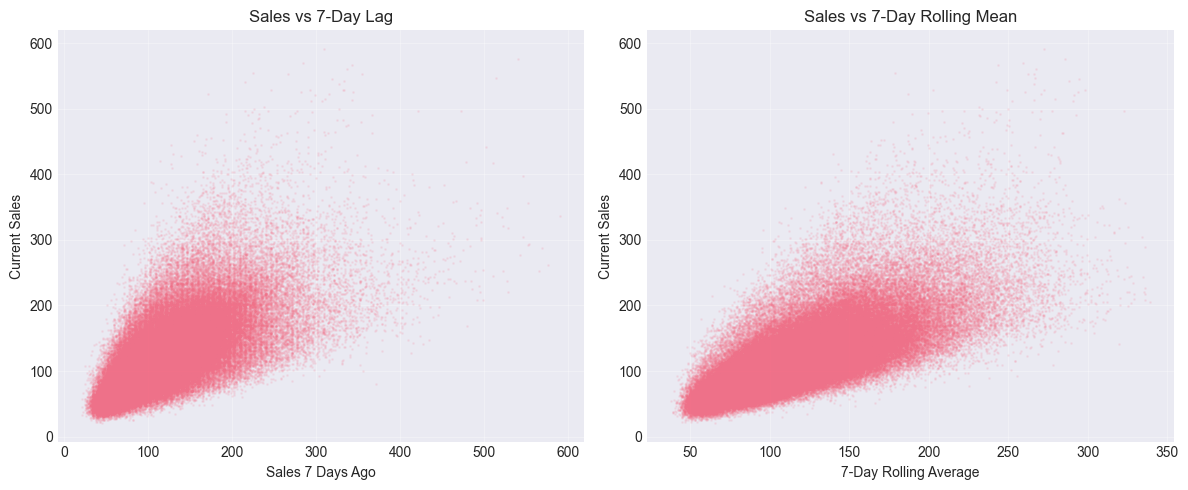


🎯 Top 15 Features Correlated with Sales:
sales_rolling_mean_14    0.723690
sales_rolling_mean_7     0.719914
sales_rolling_mean_28    0.712902
sales_rolling_min_7      0.701875
sales_rolling_min_14     0.701163
sales_lag_7              0.690250
sales_rolling_min_28     0.682650
sales_lag_14             0.668441
sales_rolling_max_28     0.638347
sales_rolling_max_14     0.636699
sales_lag_1              0.633947
sales_rolling_max_7      0.632567
sales_lag_28             0.626054
sales_rolling_std_28     0.600658
sales_rolling_std_14     0.542464
Name: sales, dtype: float64


In [13]:
# Cell 9: Visualize Some Key Features
print("📊 Visualizing Key Features...")

# Example: Lag 7 vs Current Sales
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['sales_lag_7'], df['sales'], alpha=0.1, s=1)
plt.xlabel('Sales 7 Days Ago')
plt.ylabel('Current Sales')
plt.title('Sales vs 7-Day Lag')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(df['sales_rolling_mean_7'], df['sales'], alpha=0.1, s=1)
plt.xlabel('7-Day Rolling Average')
plt.ylabel('Current Sales')
plt.title('Sales vs 7-Day Rolling Mean')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation with target
print("\n🎯 Top 15 Features Correlated with Sales:")
correlations = df.corr()['sales'].abs().sort_values(ascending=False)[1:16]
print(correlations)

In [14]:
# Cell 10: Save Processed Data
import os

os.makedirs('../data/processed', exist_ok=True)
output_path = '../data/processed/features_engineered.csv'
df.to_csv(output_path, index=False)

print("=" * 60)
print("✅ FEATURE ENGINEERING COMPLETE!")
print("=" * 60)
print(f"📁 Saved to: {output_path}")
print(f"📊 Final shape: {df.shape}")
print(f"📈 Total features: {df.shape[1]}")
print(f"📅 Date range: {df['date'].min()} to {df['date'].max()}")
print("=" * 60)

print("\n🎯 Features created:")
print(f"   • Lag features: {len([c for c in df.columns if 'lag' in c])}")
print(f"   • Rolling features: {len([c for c in df.columns if 'rolling' in c])}")
print(f"   • Time features: 10+")
print(f"   • Price features: 2")
print(f"   • Interaction features: 5")
print("\n✅ Ready for modeling!")

✅ FEATURE ENGINEERING COMPLETE!
📁 Saved to: ../data/processed/features_engineered.csv
📊 Final shape: (175500, 53)
📈 Total features: 53
📅 Date range: 2023-01-29 00:00:00 to 2024-12-30 00:00:00

🎯 Features created:
   • Lag features: 4
   • Rolling features: 12
   • Time features: 10+
   • Price features: 2
   • Interaction features: 5

✅ Ready for modeling!
